In [1]:
import xarray as xr
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

In [2]:
all_pr_model_files = glob.glob("O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\Climex DK Domain\\pr_daily_bc_V2\\**\\*.nc")

In [3]:
forced_model_names = [file.split("pr_EUR")[1].split("_v")[0] for file in all_pr_model_files]

In [4]:
unique_model_names = sorted(list(set(forced_model_names)))

In [5]:
unique_model_names

['-11_CCCma-CanESM2_historical_r1-r10i1p1_OURANOS-CRCM5_kbj_day_1951-2100_BC_Esbjerg.nc',
 '-11_CCCma-CanESM2_historical_r1-r1i1p1_OURANOS-CRCM5_kba_day_1951-2100_BC_Esbjerg.nc',
 '-11_CCCma-CanESM2_historical_r1-r2i1p1_OURANOS-CRCM5_kbb_day_1951-2100_BC_Esbjerg.nc',
 '-11_CCCma-CanESM2_historical_r1-r3i1p1_OURANOS-CRCM5_kbc_day_1951-2100_BC_Esbjerg.nc',
 '-11_CCCma-CanESM2_historical_r1-r4i1p1_OURANOS-CRCM5_kbd_day_1951-2100_BC_Esbjerg.nc',
 '-11_CCCma-CanESM2_historical_r1-r5i1p1_OURANOS-CRCM5_kbe_day_1951-2100_BC_Esbjerg.nc',
 '-11_CCCma-CanESM2_historical_r1-r6i1p1_OURANOS-CRCM5_kbf_day_1951-2100_BC_Esbjerg.nc',
 '-11_CCCma-CanESM2_historical_r1-r7i1p1_OURANOS-CRCM5_kbg_day_1951-2100_BC_Esbjerg.nc',
 '-11_CCCma-CanESM2_historical_r1-r8i1p1_OURANOS-CRCM5_kbh_day_1951-2100_BC_Esbjerg.nc',
 '-11_CCCma-CanESM2_historical_r1-r9i1p1_OURANOS-CRCM5_kbi_day_1951-2100_BC_Esbjerg.nc',
 '-11_CCCma-CanESM2_historical_r2-r10i1p1_OURANOS-CRCM5_kbt_day_1951-2100_BC_Esbjerg.nc',
 '-11_CCCma-CanESM2

In [16]:
climex_df = pd.DataFrame()

In [17]:
for model in list(unique_model_names):
    print(model)

    #Select corresponding GCM model name 
    model_name = re.search(r'historical_(.*?)_OURANOS', model)
    model_name = model_name.group(1)
    model_name = model_name.replace('-', '_')
    print(model_name)
    
    #Pathway to GMST 
    GMST_file_path = glob.glob(f"O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX\\GMST\\tas_Amon_CanESM2_historical-{model_name}_1950-2100_SpatialMean_y.nc")
        
    #Open GMST file
    GMST_ds = xr.open_dataset(GMST_file_path[0])
    
    #Create year variable 
    GMST_ds['year'] = GMST_ds['time']
    
    #Calculate anomalies relative to pre-industrial (286.99 K)
    GMST_ds['tas'] = GMST_ds['tas'] - 286.99
    
    #Calculate rolling mean
    GMST_ds['tas'] = GMST_ds.tas.rolling(time=4, min_periods=1).mean()
    
    #Save to dataframe
    GMST_df = GMST_ds.tas.to_dataframe().reset_index()
    
    GMST_df['year'] = GMST_df['time'].apply(lambda x: x.year)
    GMST_df = GMST_df.drop(columns=['lat', 'lon', 'height', 'time'])  # drop the columns
    
    # Open multiple files 
    pr_ds = xr.open_mfdataset(f"O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\Climex DK Domain\\pr_daily_bc_V2\\**\\pr_EUR{model}")
    
    # Define smaller domain
    # Define your latitude and longitude bounds
    #lat_min, lat_max = 5.0, 5.3
    #lon_min, lon_max = -5.6, -5.0

    #Select domain
    #pr_ds = pr_ds.sel(rlat=slice(lat_min, lat_max), rlon=slice(lon_min, lon_max))
    
    # Select data 
    pr_ds = pr_ds.sel(
    time=(
    (pr_ds["time"].dt.year >= 1950) &  # Select years >= 1950
    (pr_ds["time"].dt.year <= 2024) & # Select years <= 2024 or 2050
    #(pr_ds["time"].dt.month >= 5) & #May
    #(pr_ds["time"].dt.month <= 9) #September
        ), drop = True)
    
    #Create year variable
    pr_ds['year'] = pr_ds['time'].dt.year
        
    #Compute Rx1day for each pixel for each year
    pr_ds_max_per_pixel = pr_ds.groupby('year').max(dim="time")
    
    #Find the maximum value across the spatial domain for each year
    pr_ds_max_overall = pr_ds_max_per_pixel.max(dim=["rlat", "rlon"]) 
        
    #Save to dataframe
    model_annual_max_df = pr_ds_max_overall.pr.to_dataframe().reset_index()
    
    combined_df = pd.merge(model_annual_max_df, GMST_df, on='year', how='inner')  

    # Append the current combined_df to climex_df
    climex_df = pd.concat([climex_df, combined_df], ignore_index = True)


-11_CCCma-CanESM2_historical_r1-r10i1p1_OURANOS-CRCM5_kbj_day_1951-2100_BC_Esbjerg.nc
r1_r10i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r1-r1i1p1_OURANOS-CRCM5_kba_day_1951-2100_BC_Esbjerg.nc
r1_r1i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r1-r2i1p1_OURANOS-CRCM5_kbb_day_1951-2100_BC_Esbjerg.nc
r1_r2i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r1-r3i1p1_OURANOS-CRCM5_kbc_day_1951-2100_BC_Esbjerg.nc
r1_r3i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r1-r4i1p1_OURANOS-CRCM5_kbd_day_1951-2100_BC_Esbjerg.nc
r1_r4i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r1-r5i1p1_OURANOS-CRCM5_kbe_day_1951-2100_BC_Esbjerg.nc
r1_r5i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r1-r6i1p1_OURANOS-CRCM5_kbf_day_1951-2100_BC_Esbjerg.nc
r1_r6i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r1-r7i1p1_OURANOS-CRCM5_kbg_day_1951-2100_BC_Esbjerg.nc
r1_r7i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r1-r8i1p1_OURANOS-CRCM5_kbh_day_1951-2100_BC_Esbjerg.nc
r1_r8i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r1-r9i1p1_OURANOS-CRCM5_kbi_day_1951-2100_BC_Esbjerg.nc
r1_r9i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r2-r10i1p1_OURANOS-CRCM5_kbt_day_1951-2100_BC_Esbjerg.nc
r2_r10i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r2-r1i1p1_OURANOS-CRCM5_kbk_day_1951-2100_BC_Esbjerg.nc
r2_r1i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r2-r2i1p1_OURANOS-CRCM5_kbl_day_1951-2100_BC_Esbjerg.nc
r2_r2i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r2-r3i1p1_OURANOS-CRCM5_kbm_day_1951-2100_BC_Esbjerg.nc
r2_r3i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r2-r4i1p1_OURANOS-CRCM5_kbn_day_1951-2100_BC_Esbjerg.nc
r2_r4i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r2-r5i1p1_OURANOS-CRCM5_kbo_day_1951-2100_BC_Esbjerg.nc
r2_r5i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r2-r6i1p1_OURANOS-CRCM5_kbp_day_1951-2100_BC_Esbjerg.nc
r2_r6i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r2-r7i1p1_OURANOS-CRCM5_kbq_day_1951-2100_BC_Esbjerg.nc
r2_r7i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r2-r8i1p1_OURANOS-CRCM5_kbr_day_1951-2100_BC_Esbjerg.nc
r2_r8i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r2-r9i1p1_OURANOS-CRCM5_kbs_day_1951-2100_BC_Esbjerg.nc
r2_r9i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r3-r10i1p1_OURANOS-CRCM5_kcd_day_1951-2100_BC_Esbjerg.nc
r3_r10i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r3-r1i1p1_OURANOS-CRCM5_kbu_day_1951-2100_BC_Esbjerg.nc
r3_r1i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r3-r2i1p1_OURANOS-CRCM5_kbv_day_1951-2100_BC_Esbjerg.nc
r3_r2i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r3-r3i1p1_OURANOS-CRCM5_kbw_day_1951-2100_BC_Esbjerg.nc
r3_r3i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r3-r4i1p1_OURANOS-CRCM5_kbx_day_1951-2100_BC_Esbjerg.nc
r3_r4i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r3-r5i1p1_OURANOS-CRCM5_kby_day_1951-2100_BC_Esbjerg.nc
r3_r5i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r3-r6i1p1_OURANOS-CRCM5_kbz_day_1951-2100_BC_Esbjerg.nc
r3_r6i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r3-r7i1p1_OURANOS-CRCM5_kca_day_1951-2100_BC_Esbjerg.nc
r3_r7i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r3-r8i1p1_OURANOS-CRCM5_kcb_day_1951-2100_BC_Esbjerg.nc
r3_r8i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r3-r9i1p1_OURANOS-CRCM5_kcc_day_1951-2100_BC_Esbjerg.nc
r3_r9i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r4-r10i1p1_OURANOS-CRCM5_kcn_day_1951-2100_BC_Esbjerg.nc
r4_r10i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r4-r1i1p1_OURANOS-CRCM5_kce_day_1951-2100_BC_Esbjerg.nc
r4_r1i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r4-r2i1p1_OURANOS-CRCM5_kcf_day_1951-2100_BC_Esbjerg.nc
r4_r2i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r4-r3i1p1_OURANOS-CRCM5_kcg_day_1951-2100_BC_Esbjerg.nc
r4_r3i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r4-r4i1p1_OURANOS-CRCM5_kch_day_1951-2100_BC_Esbjerg.nc
r4_r4i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r4-r5i1p1_OURANOS-CRCM5_kci_day_1951-2100_BC_Esbjerg.nc
r4_r5i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r4-r6i1p1_OURANOS-CRCM5_kcj_day_1951-2100_BC_Esbjerg.nc
r4_r6i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r4-r7i1p1_OURANOS-CRCM5_kck_day_1951-2100_BC_Esbjerg.nc
r4_r7i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r4-r8i1p1_OURANOS-CRCM5_kcl_day_1951-2100_BC_Esbjerg.nc
r4_r8i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r4-r9i1p1_OURANOS-CRCM5_kcm_day_1951-2100_BC_Esbjerg.nc
r4_r9i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r5-r10i1p1_OURANOS-CRCM5_kcx_day_1951-2100_BC_Esbjerg.nc
r5_r10i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r5-r1i1p1_OURANOS-CRCM5_kco_day_1951-2100_BC_Esbjerg.nc
r5_r1i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r5-r2i1p1_OURANOS-CRCM5_kcp_day_1951-2100_BC_Esbjerg.nc
r5_r2i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r5-r3i1p1_OURANOS-CRCM5_kcq_day_1951-2100_BC_Esbjerg.nc
r5_r3i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r5-r4i1p1_OURANOS-CRCM5_kcr_day_1951-2100_BC_Esbjerg.nc
r5_r4i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r5-r5i1p1_OURANOS-CRCM5_kcs_day_1951-2100_BC_Esbjerg.nc
r5_r5i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r5-r6i1p1_OURANOS-CRCM5_kct_day_1951-2100_BC_Esbjerg.nc
r5_r6i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r5-r7i1p1_OURANOS-CRCM5_kcu_day_1951-2100_BC_Esbjerg.nc
r5_r7i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r5-r8i1p1_OURANOS-CRCM5_kcv_day_1951-2100_BC_Esbjerg.nc
r5_r8i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


-11_CCCma-CanESM2_historical_r5-r9i1p1_OURANOS-CRCM5_kcw_day_1951-2100_BC_Esbjerg.nc
r5_r9i1p1


C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension year because variable year is not a coordinate. To create an index for year, please first call `.set_coords('year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


In [18]:
climex_df.to_csv('O:\\Man\\Public\\sharing-4270-CERM\\MATNEW\\CC_det_attr\\annual_max_pr_CLIMEXI_hist.csv', index=False, sep = ';') #change file name based on hist, fut, smaller domain, or May-Sept

In [9]:
climex_df[climex_df['year'] == 2024]

,year,pr,tas
69,2024,42.628880,1.665245
139,2024,36.443687,1.538628
209,2024,52.558857,1.603256
279,2024,40.106598,1.594391
349,2024,34.423065,1.587959
419,2024,37.700298,1.600197
489,2024,37.362091,1.707077
559,2024,23.701973,1.554192
629,2024,36.761978,1.576195
699,2024,35.977421,1.634705


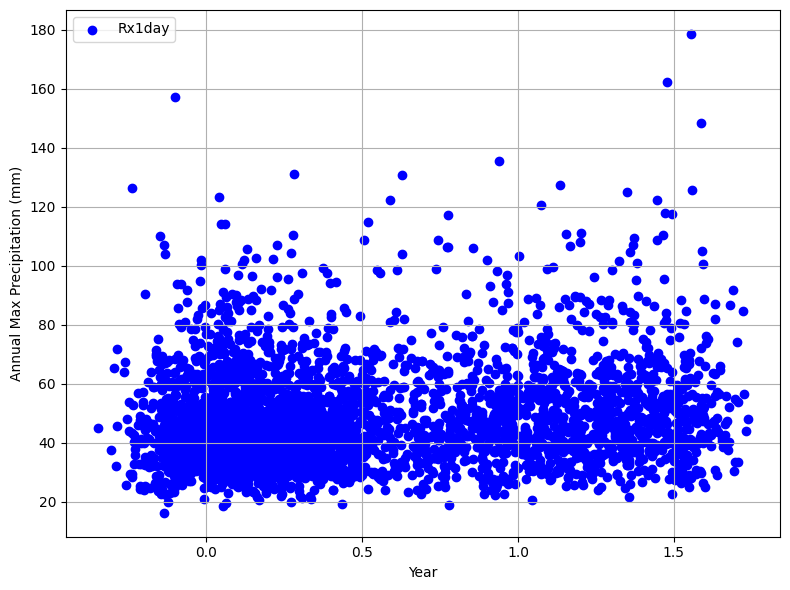

In [19]:
# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(climex_df.tas, climex_df.pr, color='blue', marker = 'o', label='Rx1day')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Annual Max Precipitation (mm)')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()